# Logistic Regression 

## Model Fitting

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from talib import BBANDS
import matplotlib.pyplot as plt

## Load the CSV file

In [2]:
# Load the CSV file and parse the "date" column as datetime, setting it as the index
data = pd.read_csv("Kucoin_BTCUSDT_d.csv", parse_dates=["date"], index_col="date", encoding="utf-8")

## Print DataFrame header

In [3]:
# Print the header of the DataFrame to verify it's loaded correctly
print(data.head())

                  unix    symbol     open     high      low    close  \
date                                                                   
2022-11-29  1669680000  BTC/USDT  16213.6  16220.8  16102.4  16168.9   
2022-11-28  1669593600  BTC/USDT  16432.1  16483.2  16000.0  16213.5   
2022-11-27  1669507200  BTC/USDT  16457.1  16597.1  16403.2  16432.1   
2022-11-26  1669420800  BTC/USDT  16520.0  16698.1  16386.1  16456.4   
2022-11-25  1669334400  BTC/USDT  16601.7  16618.9  16339.9  16519.9   

             Volume BTC   Volume USDT  
date                                   
2022-11-29   416.112589  6.723410e+06  
2022-11-28  9138.216658  1.482121e+08  
2022-11-27  4042.719155  6.683389e+07  
2022-11-26  5827.814840  9.653858e+07  
2022-11-25  6211.076373  1.024305e+08  


## Drop the unnecessary columns

In [4]:
# Define columns to drop
columns_to_drop = ["unix", "open", "Volume BTC", "Volume USDT"]

# Drop columns
data.drop(columns=columns_to_drop, inplace=True)


## Calculate Bollinger Bands

In [5]:
# Compute Bollinger Bands using the closing prices
data["middle_band"], data["upper_band"], data["lower_band"] = BBANDS(data["close"], timeperiod=20)

## Calculate returns and direction

In [6]:
data["returns"] = np.log(data["close"]).diff()
data["direction"] = np.sign(data.returns)

## Shift returns to create lagged features

In [7]:
lags = 3
cols = []
for lag in range(1, lags + 1):
    col = "lag{}".format(lag)
    data[col] = data["returns"].shift(lag)
    cols.append(col)

# Drop rows with missing values
data.dropna(inplace=True)

## Normalize Bollinger Bands

In [8]:
scaler = MinMaxScaler()
data[["middle_band", "upper_band", "lower_band"]] = scaler.fit_transform(data[["middle_band", "upper_band", "lower_band"]])

## Prepare features and target

In [9]:
X = data[cols + ["middle_band", "upper_band", "lower_band"]]
y = data["direction"]

## Fit Logistic Regression model
1. LogisticRegression is a class from the sklearn.linear_model module, which implements logistic regression for classification problems.
2. C=1e6 specifies the regularization strength, where a larger value of C indicates less regularization. In this case, C=1e6 means a very small amount of regularization.
3. max_iter=100000 sets the maximum number of iterations for the solver to converge. Since logistic regression is an iterative optimization algorithm, max_iter determines the maximum number of iterations before the algorithm stops.
4. multi_class="ovr" specifies the strategy for handling multiple classes. In this case, it stands for "One-vs-Rest," which means the model will fit separate classifiers for each class, treating each class as the positive class and the rest as the negative class.

In [10]:
lm = LogisticRegression(C=1e6, max_iter=100000, multi_class="ovr")
lm.fit(X, y)

LogisticRegression(C=1000000.0, max_iter=100000, multi_class='ovr')

## Make predictions

In [11]:
# Make predictions
data["pred"] = lm.predict(X)

## Convert datetime index to numerical values

In [12]:
numeric_index = range(len(data))

## Print the DataFrame

In [13]:
print(data[['direction', 'pred']])

            direction  pred
date                       
2022-11-10        1.0   1.0
2022-11-09       -1.0   1.0
2022-11-08        1.0   1.0
2022-11-07        1.0  -1.0
2022-11-06        1.0   1.0
...               ...   ...
2017-10-23        1.0  -1.0
2017-10-22        1.0  -1.0
2017-10-21       -1.0   1.0
2017-10-20       -1.0   1.0
2017-10-19       -1.0  -1.0

[1842 rows x 2 columns]


## Evaluate the trade results incorporating SL and TP levels

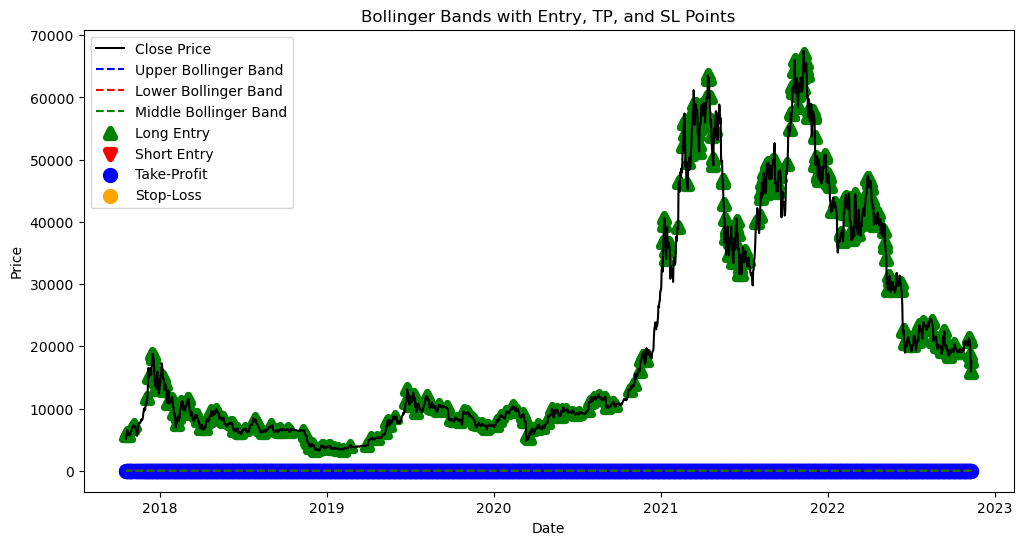

In [14]:
# Determine entry points based on the predicted direction and Bollinger Bands
data['entry_signal'] = np.where((data['pred'] == 1) & (data['close'] > data['upper_band']), 1, 
                                np.where((data['pred'] == -1) & (data['close'] < data['lower_band']), -1, 0))

# Set TP and SL levels (e.g., 8% above middle band for TP and 5% below middle band for SL)
tp_percentage = 0.09
sl_percentage = 0.05

# Calculate TP and SL prices based on the middle Bollinger Band
data['entry_price'] = np.where(data['entry_signal'] != 0, data['close'], np.nan)
data['tp_price'] = data['middle_band'] * (1 + tp_percentage)
data['sl_price'] = data['middle_band'] * (1 - sl_percentage)

# Implement TP and SL conditions
data['tp_hit'] = np.where(data['high'] >= data['tp_price'], 1, 0)
data['sl_hit'] = np.where(data['low'] <= data['sl_price'], 1, 0)

# Visualize entry, TP, and SL points
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Close Price', color='black')
plt.plot(data.index, data['upper_band'], label='Upper Bollinger Band', color='blue', linestyle='--')
plt.plot(data.index, data['lower_band'], label='Lower Bollinger Band', color='red', linestyle='--')
plt.plot(data.index, data['middle_band'], label='Middle Bollinger Band', color='green', linestyle='--')
plt.scatter(data[data['entry_signal'] == 1].index, data[data['entry_signal'] == 1]['close'], label='Long Entry', color='green', marker='^', linewidths=5)
plt.scatter(data[data['entry_signal'] == -1].index, data[data['entry_signal'] == -1]['close'], label='Short Entry', color='red', marker='v', linewidths=5)
plt.scatter(data[data['tp_hit'] == 1].index, data[data['tp_hit'] == 1]['tp_price'], label='Take-Profit', color='blue', marker='o', linewidths=5)
plt.scatter(data[data['sl_hit'] == 1].index, data[data['sl_hit'] == 1]['sl_price'], label='Stop-Loss', color='orange', marker='o', linewidths=5)
plt.title('Bollinger Bands with Entry, TP, and SL Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Evaluate model performance

In [15]:
# Fit Logistic Regression model
print("Fitting the logistic regression model...")
lm.fit(X, y)

# Verify if the model is fitted
if lm.__getstate__():
    print("Logistic regression model is fitted.")
else:
    print("Logistic regression model is not fitted.")

# Calculate the predictions
predictions = lm.predict(X)

# Evaluate trade results
trades = pd.DataFrame(index=data.index)
trades['actual_direction'] = data['direction']
trades['predicted_direction'] = predictions

# Calculate TP and SL prices
tp_price = data['close'] * (1 + tp_percentage)
sl_price = data['close'] * (1 - sl_percentage)

# Evaluate trade results
trades['tp_hit'] = np.where(data['high'] >= tp_price, 1, 0)
trades['sl_hit'] = np.where(data['low'] <= sl_price, 1, 0)
trades['profit'] = np.where((trades['predicted_direction'] == 1) & (trades['tp_hit'] == 1), (tp_price - data['close']), np.where((trades['predicted_direction'] == -1) & (trades['tp_hit'] == 1), (data['close'] - tp_price), np.where((trades['predicted_direction'] == 1) & (trades['sl_hit'] == 1), (sl_price - data['close']), np.where((trades['predicted_direction'] == -1) & (trades['sl_hit'] == 1), (data['close'] - sl_price), 0))))

# Calculate trade performance metrics
total_trades = len(trades)
profitable_trades = (trades['profit'] > 0).sum()
total_profit = trades['profit'].sum()
average_profit_per_trade = total_profit / total_trades

# Print trade performance metrics
print("Total Trades:", total_trades)
print("Profitable Trades:", profitable_trades)
print("Total Profit:", total_profit)
print("Average Profit per Trade:", average_profit_per_trade)


Fitting the logistic regression model...
Logistic regression model is fitted.
Total Trades: 1842
Profitable Trades: 235
Total Profit: 23714.17449525172
Average Profit per Trade: 12.874144677118197


In [16]:
# Filter profitable trades
profitable_trades_df = trades[trades['profit'] > 0]

# Calculate additional metrics
total_trades = len(trades)
profitable_trades = len(profitable_trades_df)
total_profit = trades['profit'].sum()
average_profit_per_trade = total_profit / total_trades
max_drawdown = trades['profit'].cumsum().min()
profit_factor = total_profit / trades[trades['profit'] < 0]['profit'].sum()

# Print the refined evaluation metrics
print("Total Trades:", total_trades)
print("Profitable Trades:", profitable_trades)
print("Total Profit:", total_profit)
print("Average Profit per Trade:", average_profit_per_trade)
print("Maximum Drawdown:", max_drawdown)
print("Profit Factor:", profit_factor)

Total Trades: 1842
Profitable Trades: 235
Total Profit: 23714.17449525172
Average Profit per Trade: 12.874144677118197
Maximum Drawdown: -9724.630000000005
Profit Factor: -0.10014907621456094


## Bar plot count of correct and incorrect predictions

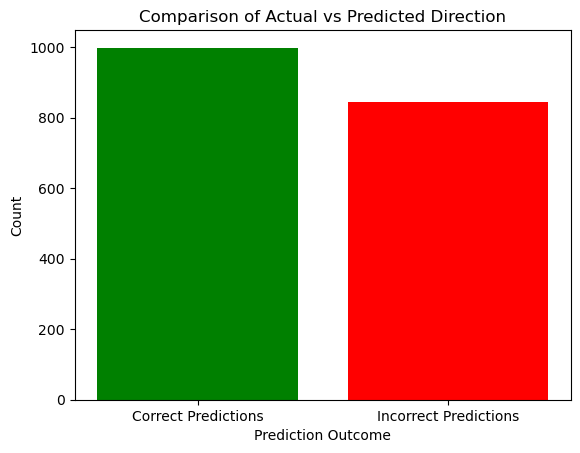

In [17]:
import matplotlib.pyplot as plt

# Count correct and incorrect predictions
correct_predictions = ((data['direction'] == 1) & (data['pred'] == 1)).sum() + ((data['direction'] == -1) & (data['pred'] == -1)).sum()
incorrect_predictions = ((data['direction'] == 1) & (data['pred'] == -1)).sum() + ((data['direction'] == -1) & (data['pred'] == 1)).sum()

# Plot
plt.bar(['Correct Predictions', 'Incorrect Predictions'], [correct_predictions, incorrect_predictions], color=['green', 'red'])
plt.title('Comparison of Actual vs Predicted Direction')
plt.xlabel('Prediction Outcome')
plt.ylabel('Count')
plt.show()

## Save the trained model

In [18]:
import pickle

# Attempt to save the model to a pickle file
try:
    # Open the file in binary write mode
    with open("logreg_with_bollinger.pkl", "wb") as f:
        # Dump the object into the file
        pickle.dump(lm, f)
    print("Model saved successfully to logreg_with_bollinger.pkl")
except Exception as e:
    print("Error occurred while saving the model:", e)

# Attempt to load the saved model back from the pickle file and verify its integrity
try:
    # Open the file in binary read mode
    with open("logreg_with_bollinger.pkl", "rb") as f:
        # Load the model from the file
        loaded_model = pickle.load(f)
    # Check if the loaded model matches the original model
    if str(loaded_model) == str(lm):
        print("Loaded model matches the original model.")
    else:
        print("Error: Loaded model does not match the original model.")
except Exception as e:
    print("Error occurred while loading the saved model:", e)

Model saved successfully to logreg_with_bollinger.pkl
Loaded model matches the original model.


# machine learning implementation

In [19]:
import pandas as pd
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
import ccxt
from datetime import datetime, timedelta
import time
import pickle
import logging 
from pytz import UTC
import talib

In [20]:
class MLTrader:
    def __init__(self, instrument, lags, model_path, units, leverage):
        self.instrument = instrument
        self.leverage = leverage
        self.exchange = ccxt.kucoinfutures({
            'apiKey': os.getenv('API_KEY'),
            'secret': os.getenv('SECRET_KEY'),
            'password': os.getenv('PASSPHRASE'),
            'enableRateLimit': True
        })
        self.bar_length = "1h"
        self.tick_data = pd.DataFrame()
        self.raw_data = None
        self.data = None 
        self.last_bar = None
        self.units = units
        self.position = 0
        self.profits = []
        self.lags = lags
        self.load_model(model_path)
                
    def load_model(self, model_path):
        try:
            self.model = pickle.load(open(model_path, "rb"))
        except Exception as e:
            logging.error(f"Error loading model: {e}")
            raise   
                
    def get_most_recent(self, days=5, data_count=0, stop_condition=200):
        while True:
            time.sleep(2)
            now_utc = datetime.utcnow().replace(tzinfo=UTC)  # Make current time timezone-aware
            past_utc = now_utc - timedelta(days=days)
            ohlcv = self.exchange.fetch_ohlcv(self.instrument, timeframe=self.bar_length,
                                               since=int(past_utc.timestamp()) * 1000)
            df = pd.DataFrame(ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
            df.set_index("timestamp", inplace=True)

            # Append fetched data to raw_data
            if self.raw_data is None:
                self.raw_data = df
            else:
                self.raw_data = pd.concat([self.raw_data, df])

            self.last_bar = self.raw_data.index[-1].replace(tzinfo=UTC)  # Make last bar timezone-aware

            # Check if stop condition is met
            if len(self.raw_data) >= stop_condition:
                break

            # Check if last fetched data is within the desired timeframe
            if now_utc - self.last_bar < pd.to_timedelta(self.bar_length):
                break

                
    def on_success(self, time, bid, ask):
        print(self.ticks, end = " ")
        
        recent_tick = pd.to_datetime(time)
        df = pd.DataFrame({self.instrument:(ask + bid)/2}, 
                          index = [recent_tick])
        self.tick_data = pd.concat([self.tick_data, df]) # new with pd.concat()
        
        if recent_tick - self.last_bar > pd.to_timedelta(self.bar_length):
            self.resample_and_join()
            self.define_strategy()
            self.execute_trades()
    
    def resample_and_join(self):
        self.raw_data = pd.concat([self.raw_data, self.tick_data.resample(self.bar_length, 
                                                                          label="right").last().ffill().iloc[:-1]])
        self.tick_data = self.tick_data.iloc[-1:]
        self.last_bar = self.raw_data.index[-1]
    
    def define_strategy(self):
        if self.raw_data is not None and not self.raw_data.empty:
            df = self.raw_data.copy()

            #******************** define your strategy here ************************
            print("Raw data before concatenation:")
            print(df)

            df = pd.concat([df, self.tick_data]) # new with pd.concat

            print("Raw data after concatenation with tick data:")
            print(df)

            df["returns"] = np.log(df["close"] / df["close"].shift())
            cols = []
            for lag in range(1, self.lags + 1):
                col = "lag{}".format(lag)
                df[col] = df["returns"].shift(lag)
                cols.append(col)
            df.dropna(inplace = True)
            
            # Calculate Bollinger Bands
            df['middle_band'], df['upper_band'], df['lower_band'] = talib.BBANDS(df['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

            print("Preprocessed data with lag features and Bollinger Bands:")
            print(df)

            # Use lm.predict instead of self.model.predict
            predicted_positions = self.model.predict(df[cols])
            df["position"] = predicted_positions

            print("Data with predicted positions:")
            print(df)
            #***********************************************************************

            self.data = df.copy()
        else:
            print("Raw data is empty or None. Cannot define strategy.")
    
    def execute_trades(self):
        if self.data is None or self.data.empty:
            logging.warning("No data available for trading.")
            return
        
        trading_signal = "long" if self.data["position"].iloc[-1] == 1 else ("short" if self.data["position"].iloc[-1] == -1 else "neutral")
        trading_size = self.units * 2 if abs(self.position) == 1 else self.units
        
        if self.position != 0:
            side = 'buy' if trading_signal == 'long' else 'sell'
            limit_order_params = {
                'symbol': self.instrument,
                'type': 'limit',
                'side': side,
                'amount': trading_size,
                'price': self.data['close'].iloc[-1],
                'params': {
                    'postOnly': False,
                    'timeInForce': 'GTC',
                    'leverage': self.leverage,
                }
            }
            
            try:
                order = self.exchange.create_order(**limit_order_params)
                self.report_trade(order, f"GOING {trading_signal.upper()}")
                self.position = 0  # Reset position after executing trade
            except Exception as e:
                logging.error(f"Error executing trade: {e}")
        else:  # Additional logic for the case when self.position == 0
            if self.data["position"].iloc[-1] == 1:
                order = self.exchange.create_order(self.instrument, 'limit', 'buy', self.units, suppress=True, ret=True)
                self.report_trade(order, "GOING LONG")
                self.position = 1
            elif self.data["position"].iloc[-1] == -1:
                order = self.exchange.create_order(self.instrument, 'limit', 'sell', self.units, suppress=True, ret=True)
                self.report_trade(order, "GOING SHORT")
                self.position = -1
            else:  # self.data["position"].iloc[-1] == 0
                logging.info("No trading signal, position remains neutral.")
                self.position = 0  # Reset position to ensure it remains neutral
    
    def report_trade(self, order, going):
        time = order["time"]
        units = order["units"]
        price = order["price"]
        pl = float(order["pl"])
        self.profits.append(pl)
        cumpl = sum(self.profits)
        print("\n" + 100* "-")
        print("{} | {}".format(time, going))
        print("{} | units = {} | price = {} | P&L = {} | Cum P&L = {}".format(time, units, price, pl, cumpl))
        print(100 * "-" + "\n")


In [21]:
lm = LogisticRegression(C = 1e6, max_iter = 100000, multi_class = "ovr")

In [22]:
lm

LogisticRegression(C=1000000.0, max_iter=100000, multi_class='ovr')

In [ ]:
lm = pickle.load(open("logreg.pkl", "rb"))

# Instantiate MLTrader object
trader = MLTrader(instrument="BTC/USDT:USDT", lags=3, model_path="logreg.pkl", units=1, leverage=5)


# Define the number of iterations or set to None for indefinite looping
num_iterations = None  # Set to None for indefinite looping

while num_iterations is None or num_iterations > 0:
    # Fetch most recent historical data
    trader.get_most_recent()
    
    # Print updated data value for debugging
    print("Updated data after fetching most recent historical data:")
    print(trader.raw_data)

    # Determine stop condition for fetching historical data
    stop_condition = 200  # Number of data points to fetch
    data_count = 0

    # Initialize an empty DataFrame to store historical data
    historical_data_df = pd.DataFrame()

    # Fetch historical data until the stop condition is met
    while data_count < stop_condition:
        try:
            # Fetch historical data using ccxt
            historical_data = trader.exchange.fetch_ohlcv(trader.instrument, timeframe='1d', limit=200)

            # Check if fetched data is empty
            if not historical_data:
                print("No more historical data available.")
                break

            # Convert fetched data into a DataFrame
            data_df = pd.DataFrame(historical_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

            # Append the fetched data to the DataFrame containing historical data
            historical_data_df = pd.concat([historical_data_df, data_df], ignore_index=True)

            # Increment the data count by the number of data points fetched in this iteration
            data_count += len(historical_data)

            # Print debug information
            #print(f"Fetched {len(historical_data)} data points. Total: {data_count}/{stop_condition}")

        except ccxt.NetworkError as e:
            print(f"Network Error fetching historical data: {e}")
            break
        except ccxt.ExchangeError as e:
            print(f"Exchange Error fetching historical data: {e}")
            break
        except Exception as e:
            print(f"Error fetching historical data: {e}")
            
    # Define trading strategy and print debug information
    trader.define_strategy()
    print("Signal detected or generated:")
    print(trader.data["position"].iloc[-1])

    # Check if there is an open position
    if trader.position != 0:
        try:
            # Determine the trading signal
            trading_signal = "long" if trader.position == 1 else "short" if trader.position == -1 else "neutral"
            
            # Create a market order to close the position
            symbol = trader.exchange.market_id(trader.instrument)
            close_order = trader.exchange.create_order(symbol, 'market', 'sell' if trader.position < 0 else 'buy',
                                                       abs(trader.position * trader.units))
            # Report the trade
            trader.report_trade(close_order, f"GOING NEUTRAL")
            trader.position = 0  # Reset position after executing trade
        except Exception as e:
            print(f"Error executing close order: {e}")

    # Access the model attribute
    trader.model

    # Decrement the number of iterations
    if num_iterations is not None:
        num_iterations -= 1

    # Sleep for 5 seconds before the next iteration
    time.sleep(60)

Updated data after fetching most recent historical data:
                        open     high      low    close     volume
timestamp                                                         
2024-03-19 09:00:00  63472.5  64231.6  62981.1  64148.6  1420795.0
2024-03-19 10:00:00  64145.5  64164.8  62699.0  63262.9  1067015.0
2024-03-19 11:00:00  63267.9  63411.9  62516.0  63081.3   934713.0
2024-03-19 12:00:00  63083.2  63838.7  63013.0  63656.8  1222467.0
2024-03-19 13:00:00  63645.9  63884.9  63061.1  63565.7  1138079.0
...                      ...      ...      ...      ...        ...
2024-03-24 04:00:00  63966.8  64307.3  63766.0  64241.3   309128.0
2024-03-24 05:00:00  64241.2  64402.3  64116.8  64316.3   149420.0
2024-03-24 06:00:00  64313.3  64433.2  64092.8  64231.7   140206.0
2024-03-24 07:00:00  64236.6  64600.0  64041.7  64600.0   148839.0
2024-03-24 08:00:00  64599.9  65008.1  64488.9  64843.4   290356.0

[120 rows x 5 columns]
Raw data before concatenation:
                 

Updated data after fetching most recent historical data:
                        open     high      low    close     volume
timestamp                                                         
2024-03-19 09:00:00  63472.5  64231.6  62981.1  64148.6  1420795.0
2024-03-19 10:00:00  64145.5  64164.8  62699.0  63262.9  1067015.0
2024-03-19 11:00:00  63267.9  63411.9  62516.0  63081.3   934713.0
2024-03-19 12:00:00  63083.2  63838.7  63013.0  63656.8  1222467.0
2024-03-19 13:00:00  63645.9  63884.9  63061.1  63565.7  1138079.0
...                      ...      ...      ...      ...        ...
2024-03-24 04:00:00  63966.8  64307.3  63766.0  64241.3   309128.0
2024-03-24 05:00:00  64241.2  64402.3  64116.8  64316.3   149420.0
2024-03-24 06:00:00  64313.3  64433.2  64092.8  64231.7   140206.0
2024-03-24 07:00:00  64236.6  64600.0  64041.7  64600.0   148839.0
2024-03-24 08:00:00  64599.9  65008.1  64488.9  64823.0   298871.0

[240 rows x 5 columns]
Raw data before concatenation:
                 